# 04 — Exploratory Data Analysis (EDA)

This notebook explores the  Cleaned labeled Netflix reviews dataset.  
It produces and saves visual assets for reporting and Streamlit.



## Load Cleaned Labeled dataset & imports

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyarrow
import sklearn

In [3]:
# Path
CLEANED_OUTPUT_LABELED_PATH = Path("../data/netflix_reviews_Cleaned.csv")

# Load
df = pd.read_csv(CLEANED_OUTPUT_LABELED_PATH)
print(f"✅ Loaded Cleaned_labeled dataset with {len(df)} rows")

# Quick peek
df.head()

✅ Loaded Cleaned_labeled dataset with 41238 rows


,username,review,rating,date,country,source,clean_review,vader_score,sentiment,sentiment_rating,sentiment_combined
0,Robert,"brainwashing children. don't deny it, the proo...",1,2025-10-08 00:57:12,NG,Play Store,brainwashing children dont deny proof pudding,-0.1190,negative,negative,negative
1,Abraham Bernabe,disgusting woke agenda. just cancel and uninst...,1,2025-10-08 00:35:03,NG,Play Store,disgusting woke agenda cancel uninstall garbage,-0.6597,negative,negative,negative
2,Kyle Martin,Please fix the pausing issue. I am trying to w...,2,2025-10-08 00:33:36,NG,Play Store,please fix pausing issue trying watch monday n...,-0.1779,negative,negative,negative
3,Jarrett,"Doesn't really have that much titles, heh lol",3,2025-10-08 00:30:51,NG,Play Store,doesnt really much titles heh lol,0.2350,positive,neutral,positive
4,Michael Raber,"gotta pay for the app, they raise the price wi...",1,2025-10-08 00:26:11,NG,Play Store,gotta pay app raise price warning work half time,-0.4215,negative,negative,negative


## Quick dataset summary


In [64]:
# Basic info and counts
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())


Columns: ['username', 'review', 'rating', 'date', 'country', 'source', 'clean_review', 'vader_score', 'sentiment', 'sentiment_rating', 'sentiment_combined']

Data types:
 username               object
review                 object
rating                  int64
date                   object
country                object
source                 object
clean_review           object
vader_score           float64
sentiment              object
sentiment_rating       object
sentiment_combined     object
dtype: object

Missing values per column:
 username              0
review                0
rating                0
date                  0
country               0
source                0
clean_review          0
vader_score           0
sentiment             0
sentiment_rating      0
sentiment_combined    0
dtype: int64


In [65]:
# Count per source
print("\nCounts by source:")
print(df['source'].value_counts())


Counts by source:
source
Play Store    39296
App Store      1942
Name: count, dtype: int64


In [66]:
# Sentiment by country
print("\nSentiment distribution by country:")
df.groupby('country')['sentiment_combined'].value_counts(normalize=True).unstack()



Sentiment distribution by country:


sentiment_combined,negative,neutral,positive
country,,,
CA,0.352696,0.168542,0.478763
GB,0.349083,0.166392,0.484525
NG,0.354961,0.170207,0.474833
US,0.357295,0.167152,0.475553


In [67]:
print("\nAverage VADER score by country:")
df.groupby('country')['vader_score'].median()



Average VADER score by country:


country
CA    0.2618
GB    0.2732
NG    0.2561
US    0.2500
Name: vader_score, dtype: float64

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41238 entries, 0 to 41237
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   username            41238 non-null  object 
 1   review              41238 non-null  object 
 2   rating              41238 non-null  int64  
 3   date                41238 non-null  object 
 4   country             41238 non-null  object 
 5   source              41238 non-null  object 
 6   clean_review        41238 non-null  object 
 7   vader_score         41238 non-null  float64
 8   sentiment           41238 non-null  object 
 9   sentiment_rating    41238 non-null  object 
 10  sentiment_combined  41238 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.5+ MB


In [69]:
df.describe()

,rating,vader_score
count,41238.000000,41238.000000
mean,2.962632,0.184308
std,1.843459,0.458324
min,1.000000,-0.964300
25%,1.000000,0.000000
50%,3.000000,0.263500
75%,5.000000,0.571900
max,5.000000,0.995100


In [70]:
df['rating'].value_counts()

rating
1    17321
5    16456
4     2638
2     2449
3     2374
Name: count, dtype: int64

In [71]:
print("\nAverage (mean) rating per sentiment class:")
print(df.groupby('sentiment_combined')['rating'].mean())

print("\nMedian rating per sentiment class:")
print(df.groupby('sentiment_combined')['rating'].median())


Average (mean) rating per sentiment class:
sentiment_combined
negative    1.178900
neutral     1.632232
positive    4.748036
Name: rating, dtype: float64

Median rating per sentiment class:
sentiment_combined
negative    1.0
neutral     1.0
positive    5.0
Name: rating, dtype: float64


In [72]:
# Mean and Median rating per Country and Source
grouped = df.groupby(['country', 'source'])['rating']
print(pd.DataFrame({
    'mean_rating': grouped.mean(),
    'median_rating': grouped.median()
}))

                    mean_rating  median_rating
country source                                
CA      App Store      3.352459            4.0
        Play Store     2.945134            3.0
GB      App Store      3.805383            5.0
        Play Store     2.945134            3.0
NG      App Store      3.141684            3.0
        Play Store     2.945134            3.0
US      App Store      2.969008            3.0
        Play Store     2.945134            3.0


In [73]:
correlation = df[['vader_score', 'rating']].corr()
print("Correlation between VADER sentiment and star rating:")
print(correlation)

Correlation between VADER sentiment and star rating:
             vader_score    rating
vader_score     1.000000  0.561552
rating          0.561552  1.000000


In [74]:
import os

# Ensure assets folder exists
os.makedirs("assets", exist_ok=True)
print("📁 'assets' folder verified/created.")


📁 'assets' folder verified/created.


## Rating Distribution


Rating distribution:


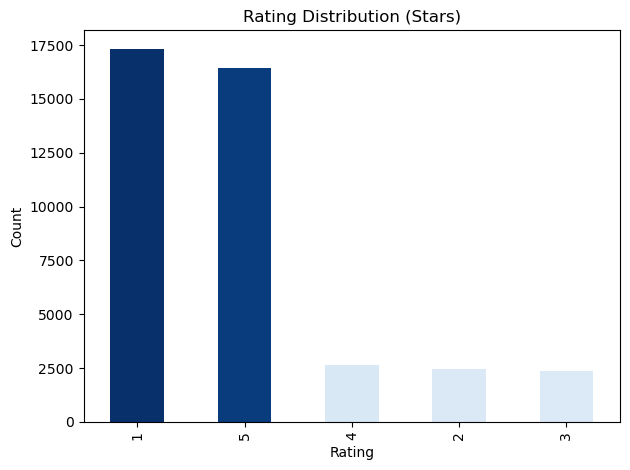

In [75]:
print("\nRating distribution:")
# Count ratings and sort descending
rating_counts = df['rating'].value_counts().sort_values(ascending=False)

# Generate colors based on counts (deeper color for higher count)
colors = plt.cm.Blues(rating_counts / rating_counts.max())

# Plot
rating_counts.plot(kind='bar', color=colors, title='Rating Distribution (Stars)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("../assets/rating_distribution.png")  # Save to ROOT assets/
plt.show()


## Sentiment Combined Distribution


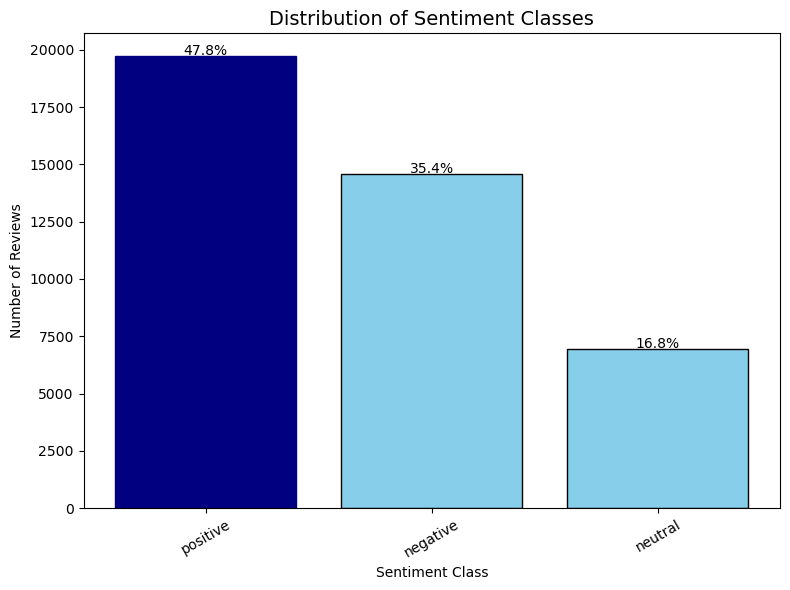

In [76]:
# Count and percentage
sent_counts = df['sentiment_combined'].value_counts().sort_values(ascending=False)
sent_percent = (sent_counts / len(df)) * 100

plt.figure(figsize=(8,6))
bars = plt.bar(sent_counts.index, sent_counts.values, color='skyblue', edgecolor='black')

# Highlight the top sentiment with deeper color
bars[0].set_color('navy')

# Add percentages above bars
for bar, pct in zip(bars, sent_percent):
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position
        bar.get_height() + 50,             # y position (slightly above bar)
        f"{pct:.1f}%",                     # percentage label
        ha='center', fontsize=10, color='black'
    )

plt.title("Distribution of Sentiment Classes", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../assets/sentiment_combined_distribution.png")
plt.show()



## Vader vs Rating vs Combined Sentiment Comparison


Cross-tab (counts):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative              8629      580       659
neutral               5369      500      2931
positive              5772     1294     15504

Cross-tab (% by text sentiment rows):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative             87.44     5.88      6.68
neutral              61.01     5.68     33.31
positive             25.57     5.73     68.69


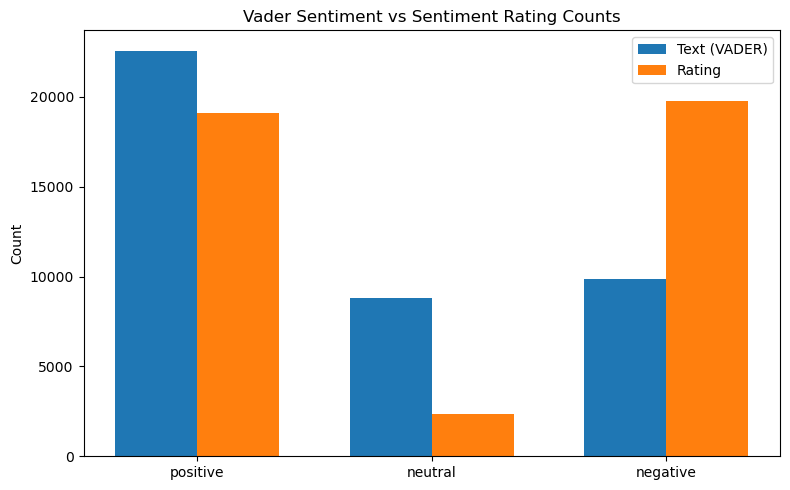

In [12]:
# Cross-tab between vader text label and rating label
ct_text_rating = pd.crosstab(df['sentiment'], df['sentiment_rating'], normalize='index') * 100
ct_text_rating_counts = pd.crosstab(df['sentiment'], df['sentiment_rating'])

print("Cross-tab (counts):\n", ct_text_rating_counts)
print("\nCross-tab (% by text sentiment rows):\n", ct_text_rating.round(2))

# Grouped bar chart: Vader text vs Rating label
labels = ['positive', 'neutral', 'negative']
x = np.arange(len(labels))
width = 0.35

text_counts = [df[df['sentiment']==lab].shape[0] for lab in labels]
rating_counts = [df[df['sentiment_rating']==lab].shape[0] for lab in labels]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, text_counts, width, label='Text (VADER)')
plt.bar(x + width/2, rating_counts, width, label='Rating')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Vader Sentiment vs Sentiment Rating Counts")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/vader_text_sentiment_vs_rating_sentiment.png")
plt.show()

Cross-tab (counts):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative                9209      659         0
neutral                 5369      500      2931
positive                   0     5772     16798

Cross-tab (% by text sentiment rows):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative               93.32     6.68      0.00
neutral                61.01     5.68     33.31
positive                0.00    25.57     74.43


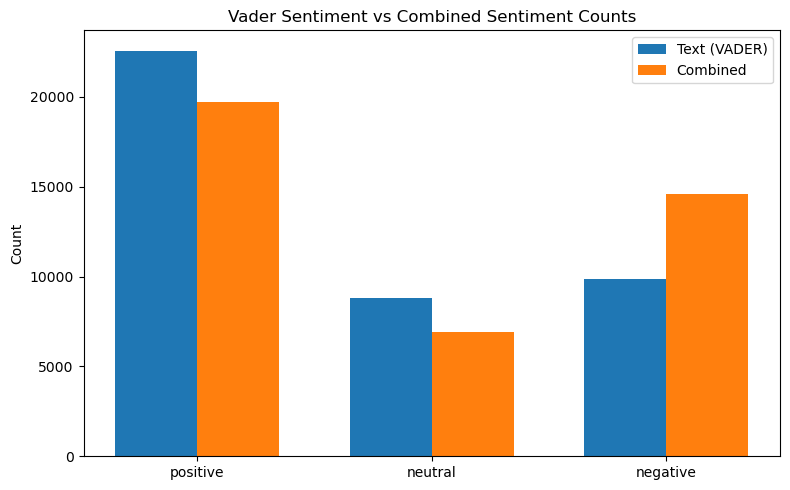

In [13]:
 
# Cross-tab vader text sentiment vs combined sentiment
ct_text_combined = pd.crosstab(df['sentiment'], df['sentiment_combined'], normalize='index') * 100
ct_text_combined_counts = pd.crosstab(df['sentiment'], df['sentiment_combined'])

print("Cross-tab (counts):\n", ct_text_combined_counts)
print("\nCross-tab (% by text sentiment rows):\n", ct_text_combined.round(2))

# Grouped bar chart: Vader text sentiment vs Combined sentiment
combined_counts = [df[df['sentiment_combined']==lab].shape[0] for lab in labels]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, text_counts, width, label='Text (VADER)')
plt.bar(x + width/2, combined_counts, width, label='Combined')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Vader Sentiment vs Combined Sentiment Counts")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/vader_text_sentiment_vs_combined_sentiment.png")
plt.show()

## Agreement vs Conflict Breakdown (Vader Text vs Rating vs combined sentiment) — how often they agree



Agreement:  24633 of 41238 (59.73%)

Disagreement breakdown (counts):
 sentiment_rating  negative  neutral  positive
sentiment                                    
negative                 0      580       659
neutral               5369        0      2931
positive              5772     1294         0


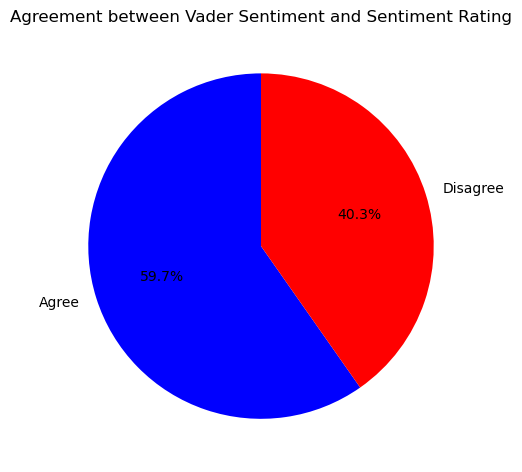

In [14]:
# Agreement between Vader text and Rating sentiment

df['text_equals_rating'] = df['sentiment'] == df['sentiment_rating']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment'], disagree_df['sentiment_rating'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Vader Sentiment and Sentiment Rating")
plt.tight_layout()
plt.savefig("../assets/vader_sentiment_text_vs_rating_sentiment_agreement.png")
plt.show()


Agreement:  26507 of 41238 (64.28%)

Disagreement breakdown (counts):
 sentiment_combined  negative  neutral  positive
sentiment                                      
negative                   0      659         0
neutral                 5369        0      2931
positive                   0     5772         0


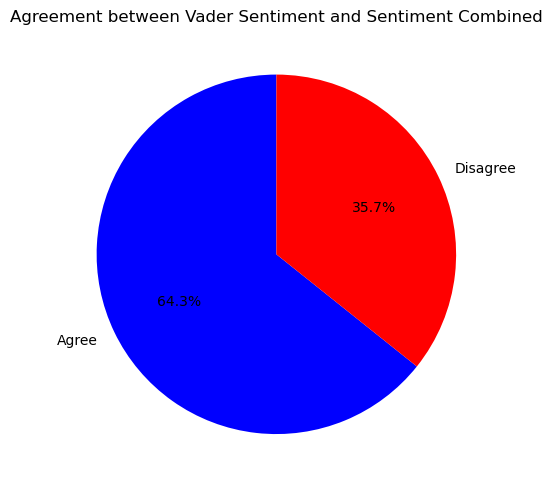

In [15]:
# Agreement between Vader text and Combined sentiment

df['text_equals_rating'] = df['sentiment'] == df['sentiment_combined']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment'], disagree_df['sentiment_combined'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Vader Sentiment and Sentiment Combined")
plt.tight_layout()
plt.savefig("../assets/vader_sentiment_text_vs_combined_sentiment_agreement.png")
plt.show()


Agreement:  32933 of 41238 (79.86%)

Disagreement breakdown (counts):
 sentiment_combined  negative  neutral  positive
sentiment_rating                               
negative                   0     5772         0
neutral                  580        0      1294
positive                   0      659         0


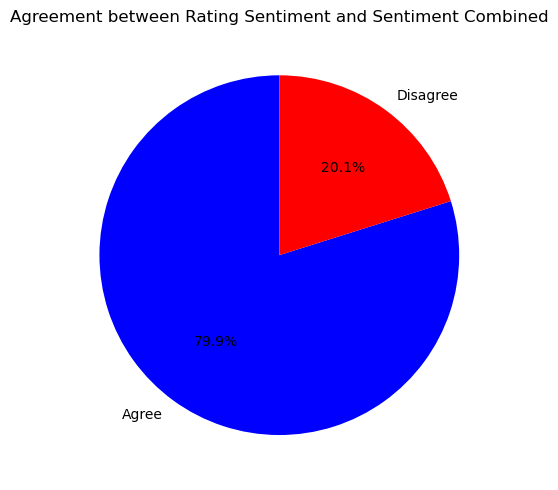

In [82]:
# Agreement between Rating sentiment and Combined sentiment

df['text_equals_rating'] = df['sentiment_rating'] == df['sentiment_combined']
agreement_count = df['text_equals_rating'].sum()
total = len(df)
agreement_pct = round(agreement_count / total * 100, 2)

# Cases where they disagree
disagree_df = df[df['text_equals_rating'] == False]

# Breakdown of disagreement types
disagree_breakdown = pd.crosstab(disagree_df['sentiment_rating'], disagree_df['sentiment_combined'])

print("\nAgreement: ", agreement_count, "of", total, f"({agreement_pct}%)")
print("\nDisagreement breakdown (counts):\n", disagree_breakdown)

# Pie chart for agreement vs disagreement
plt.figure(figsize=(5,5))
plt.pie(
    [agreement_count, total - agreement_count],
    labels=['Agree', 'Disagree'],
    autopct="%1.1f%%",
    colors=['Blue', 'Red'],
    startangle=90
)
plt.title("Agreement between Rating Sentiment and Sentiment Combined")
plt.tight_layout()
plt.savefig("../assets/sentiment_rating_vs_combined_sentiment_agreement.png")
plt.show()

In [83]:
# 3-way disagreement: Text, Rating, Combined
disagree_3way_df = df[
    ~(
        (df['sentiment'] == df['sentiment_rating']) &
        (df['sentiment'] == df['sentiment_combined'])
    )
]

# Sample up to 10 rows for review
sample_disagreements_3way = disagree_3way_df[[
    'clean_review',
    'rating',
    'vader_score',
    'sentiment',
    'sentiment_rating',
    'sentiment_combined'
]].sample(min(10, len(disagree_3way_df)), random_state=42)

sample_disagreements_3way


,clean_review,rating,vader_score,sentiment,sentiment_rating,sentiment_combined
39704,please guys stop voice narrating movieis fun w...,1,0.5267,positive,negative,neutral
3728,update juli think netflix subscribe program ye...,1,0.2263,positive,negative,neutral
672,love app wont let take screenshot scenes reall...,3,0.2975,positive,neutral,positive
36416,new netflix layout downgrade finding shows mov...,1,0.9360,positive,negative,neutral
7120,phone app decent really need update netflix ap...,3,-0.4515,negative,neutral,negative
3224,give better app pictures know,2,0.4404,positive,negative,neutral
37482,new ui samsung tv extremely bad please use old...,1,0.6581,positive,negative,neutral
26030,watch movies,5,0.0000,neutral,positive,positive
30978,wont accept smart load payment method please r...,1,0.1174,positive,negative,neutral
834,fair one country get see movie like want watch...,3,0.2732,positive,neutral,positive


## Sentiment Over Time

In [84]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Rows failed to convert:", df['date'].isna().sum())

Rows failed to convert: 1942


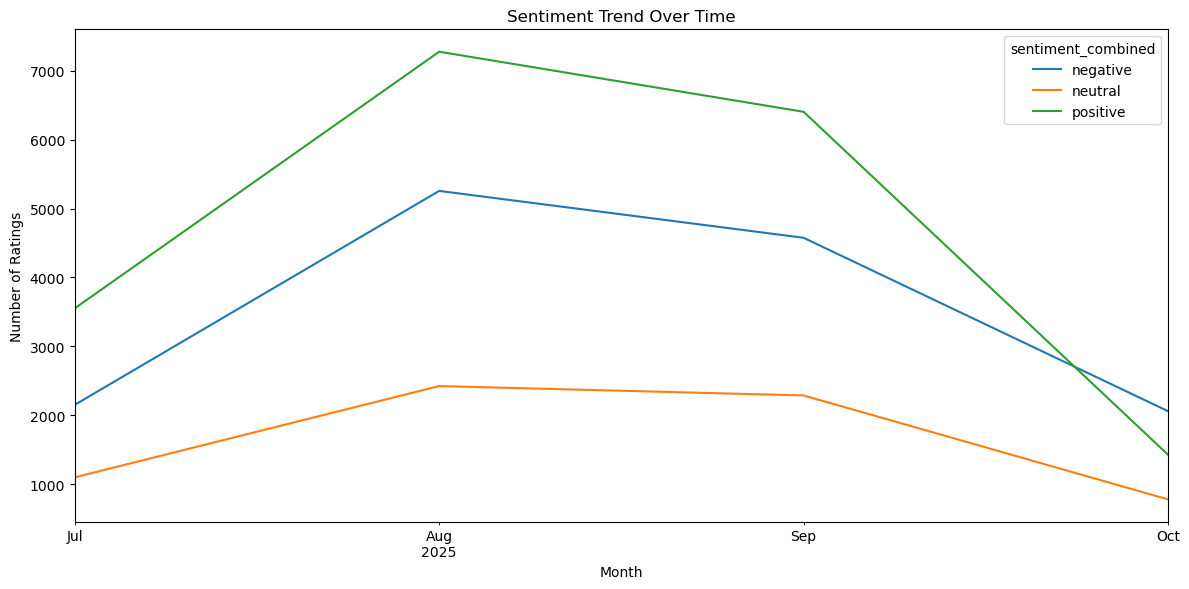

In [85]:
# Sentiment_combined trend over time
df.set_index('date').groupby('sentiment_combined')['rating'].resample('ME').count().unstack(0).plot(title='Sentiment Trend Over Time', figsize=(12,6))
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.savefig("../assets/sentiment_trend_over_time.png")
plt.show()

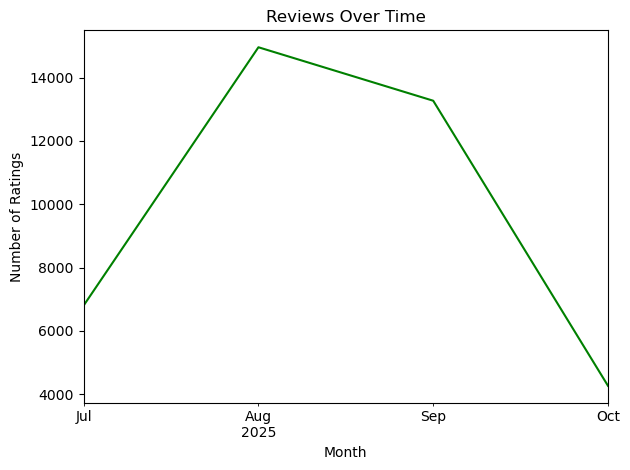

In [86]:
# rating trend over time
df.set_index('date')['rating'].resample('ME').count().plot(
    title='Reviews Over Time', color='green'
)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.savefig("../assets/reviews_over_time.png")
plt.show()

## WordCloud

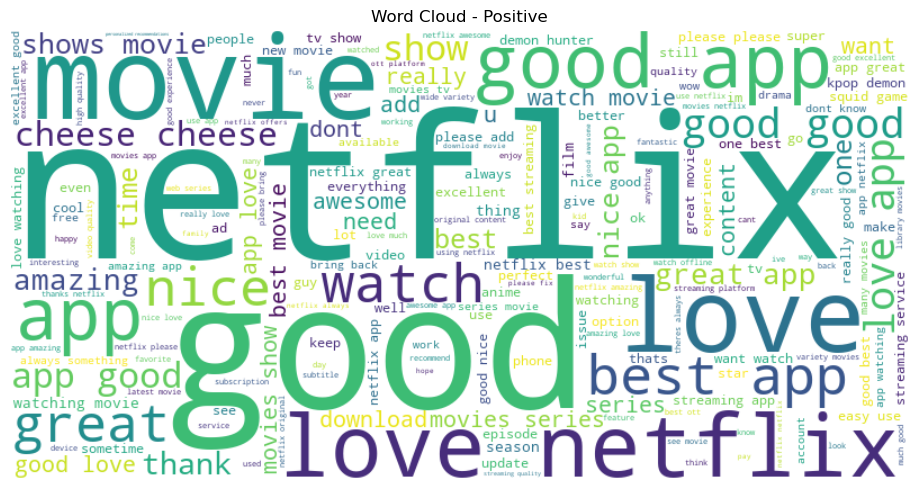

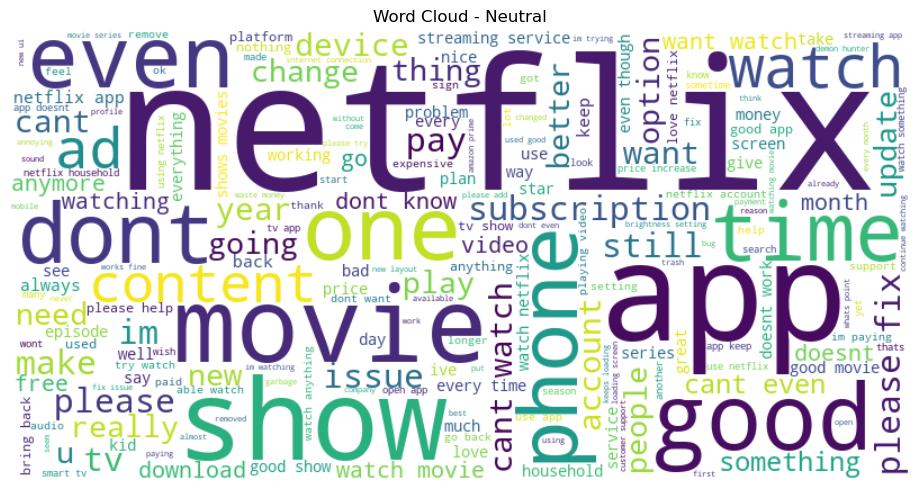

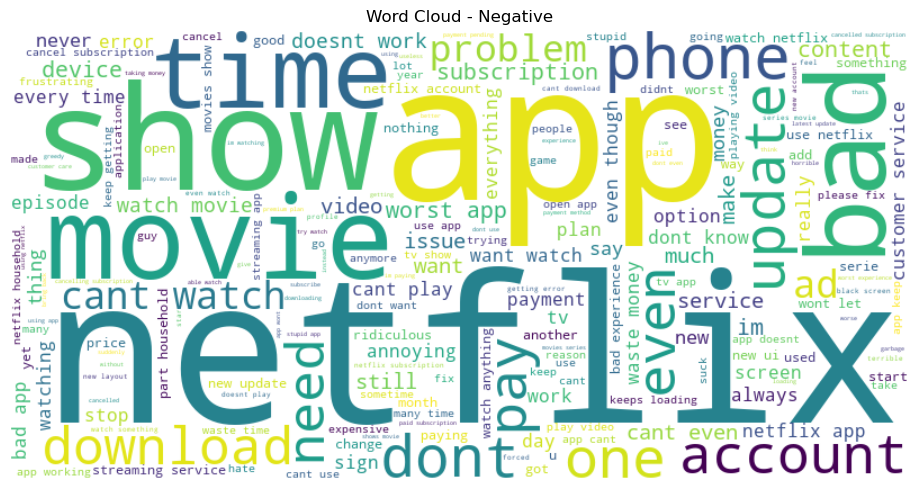

In [87]:
# Generate word clouds by sentiment category 
for sentiment in ['positive', 'neutral', 'negative']:
    subset = df[df['sentiment_combined'] == sentiment]

    if subset.empty:
        print(f"⚠ No data found for sentiment: {sentiment}")
        continue

    text = ' '.join(subset['clean_review'].dropna())

    if text.strip():
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - {sentiment.capitalize()}')
        plt.tight_layout()

        # Save as separate files: wordcloud_positive.png, wordcloud_neutral.png, wordcloud_negative.png
        plt.savefig(f"../assets/wordcloud_{sentiment}.png")
        plt.show()
    else:
        print(f"⚠ Not enough text to generate word cloud for: {sentiment}")


In [88]:
# Most common words
all_words = ' '.join(df['clean_review'].dropna()).split()
common_words = Counter(all_words).most_common(20)
print("\nTop 20 most common words:")
print(common_words)


Top 20 most common words:
[('netflix', 10604), ('app', 10333), ('good', 6093), ('watch', 4882), ('movies', 4758), ('like', 3222), ('cant', 3158), ('love', 3105), ('shows', 2998), ('even', 2563), ('dont', 2408), ('im', 2319), ('please', 2262), ('movie', 2250), ('new', 2103), ('best', 2102), ('use', 1964), ('time', 1933), ('tv', 1919), ('great', 1883)]


In [89]:
# detect top app features
# Combine all clean reviews
all_text = " ".join(df['clean_review'].astype(str))

# Tokenize words (remove non-alphanumeric)
words = re.findall(r'\b\w+\b', all_text.lower())

# remove common stopwords
stopwords = set([
    "the", "and", "is", "im", "it", "to", "for", "cant","of", "even", "dont","in", "on", "one", "get", "with", "a", "i", 
    "my", "this", "app", "movie", "movies", "show", "you", "still", "like", "want", "shows", "use", "netflix"
])
filtered_words = [w for w in words if w not in stopwords]

# Count top 20 keywords
top_keywords = Counter(filtered_words).most_common(20)
print("Top features/keywords users mention:")
for word, count in top_keywords:
    print(f"{word}: {count}")

Top features/keywords users mention:
good: 6093
watch: 4882
love: 3105
please: 2262
new: 2103
best: 2102
time: 1933
tv: 1919
great: 1883
account: 1819
subscription: 1749
phone: 1742
series: 1681
watching: 1671
content: 1597
money: 1467
nice: 1465
pay: 1403
update: 1368
really: 1366


## Mismatch Text

In [90]:
def detect_mismatches(row):
    # Positive text but low rating (1–2 stars)
    if row['sentiment_combined'] == 'positive' and row['rating'] <= 2:
        return "Positive text but low rating"
    
    # Negative text but high rating (4–5 stars)
    elif row['sentiment_combined'] == 'negative' and row['rating'] >= 4:
        return "Negative text but high rating"
    
    # Neutral text but extreme rating (1 or 5 stars)
    elif row['sentiment_combined'] == 'neutral' and (row['rating'] == 1 or row['rating'] == 5):
        return "Neutral text but extreme rating"
    
    else:
        return None


# Apply mismatch detection
df['mismatch'] = df.apply(detect_mismatches, axis=1)

# Filter mismatched rows
mismatches = df[df['mismatch'].notnull()][
    ['clean_review', 'rating', 'vader_score', 'sentiment_combined', 'mismatch']
]


print("Number of mismatched reviews:", len(mismatches))
mismatches.head(10)

Number of mismatched reviews: 5175


,clean_review,rating,vader_score,sentiment_combined,mismatch
22,month clean platform teaching kids lqbtq loss ...,1,0.1027,neutral,Neutral text but extreme rating
23,even though subscribed best plan fiber giga sp...,1,0.3400,neutral,Neutral text but extreme rating
33,sexual stuff overwhelming sure would nice watc...,1,0.5574,neutral,Neutral text but extreme rating
40,netflix go wrong,5,-0.4767,neutral,Neutral text but extreme rating
56,would like watchedseen option remove suggestio...,1,0.7184,neutral,Neutral text but extreme rating
69,original content become messaging focused unwa...,1,0.5994,neutral,Neutral text but extreme rating
75,canceled subscription supporting woke agenda,1,0.4404,neutral,Neutral text but extreme rating
83,unfortunately netflix lost respect many viewer...,1,0.8074,neutral,Neutral text but extreme rating
91,woke app promote kind uneducated child show,1,0.7184,neutral,Neutral text but extreme rating
93,stingy ads included absolutely unbelievable wo...,1,0.2610,neutral,Neutral text but extreme rating


In [91]:
# Show sample reviews from each mismatch category
for category in df['mismatch'].dropna().unique():
    print(f"\n--- {category.upper()} ---")
    sample_reviews = df[df['mismatch'] == category].sample(10, random_state=42)
    for i, row in sample_reviews.iterrows():
        print(f"User: {row['username']}, Rating: {row['rating']}, Sentiment: {row['sentiment_combined']}")
        print(f"Review: {row['clean_review'][:200]}...")  # limit to 200 chars
        print("-" * 50)


--- NEUTRAL TEXT BUT EXTREME RATING ---
User: Dave DeAngelo, Rating: 1, Sentiment: neutral
Review: recommendations tomato score star rating thumbs updown cut likely enjoy sharing playlists ai assistant help find movie mood ps ads despite free many foreign films way knowing dont understand reference...
--------------------------------------------------
User: Rajni Solanki, Rating: 1, Sentiment: neutral
Review: hi nice app live movie time...
--------------------------------------------------
User: Dan Lopez, Rating: 1, Sentiment: neutral
Review: sound quality low super quiet spatial audio missing using google pixel buds pro pixel pro xl works fine disney netflix...
--------------------------------------------------
User: Delphine Ava, Rating: 1, Sentiment: neutral
Review: top right corner screen showing glinching horizontal lines...
--------------------------------------------------
User: Leah.john, Rating: 1, Sentiment: neutral
Review: hate app changed much adverts allow cast even allo

## Postive text but low stars and also Negative text but high stars rating

In [92]:
# Positive text but low stars
pos_low = df[(df['vader_score'] >= 0.05) & (df['rating'] <= 2)]
print("Positive text but low star rating:")
print(pos_low[['clean_review', 'vader_score', 'rating']].head(10))

# Negative text but high stars
neg_high = df[(df['vader_score'] <= -0.05) & (df['rating'] >= 4)]
print("\nNegative text but high star rating:")
print(neg_high[['clean_review', 'vader_score', 'rating']].head(10))

Positive text but low star rating:
                                         clean_review  vader_score  rating
11  stars works web great tv however phone theres ...       0.5574       2
22  month clean platform teaching kids lqbtq loss ...       0.1027       1
23  even though subscribed best plan fiber giga sp...       0.3400       1
33  sexual stuff overwhelming sure would nice watc...       0.5574       1
42  next episode button stays secs rating option c...       0.5574       2
56  would like watchedseen option remove suggestio...       0.7184       1
69  original content become messaging focused unwa...       0.5994       1
73  honestly movies free sites tubi pluto better s...       0.8481       2
75       canceled subscription supporting woke agenda       0.4404       1
83  unfortunately netflix lost respect many viewer...       0.8074       1

Negative text but high star rating:
                                          clean_review  vader_score  rating
40                         

In [93]:
# Example thresholds
mismatch_reviews = df[
    ((df['vader_score'] >= 0.05) & (df['rating'] <= 2)) |   # Positive text but low rating
    ((df['vader_score'] <= -0.05) & (df['rating'] >= 4))     # Negative text but high rating
]

print(f"Number of mismatched reviews: {len(mismatch_reviews)}")
print(mismatch_reviews[['username', 'clean_review', 'rating', 'vader_score']].head(10))

Number of mismatched reviews: 6431
           username                                       clean_review  \
11       El Lawendy  stars works web great tv however phone theres ...   
22   Jason McKnight  month clean platform teaching kids lqbtq loss ...   
23  Silent Resident  even though subscribed best plan fiber giga sp...   
33            Scott  sexual stuff overwhelming sure would nice watc...   
40      Jaxson Hunt                                   netflix go wrong   
42         Kushagra  next episode button stays secs rating option c...   
56   Gerhard Maritz  would like watchedseen option remove suggestio...   
69   Lucas Hurzeler  original content become messaging focused unwa...   
73   Brianne Gamble  honestly movies free sites tubi pluto better s...   
75  Steven Larrabee       canceled subscription supporting woke agenda   

    rating  vader_score  
11       2       0.5574  
22       1       0.1027  
23       1       0.3400  
33       1       0.5574  
40       5      -0.4

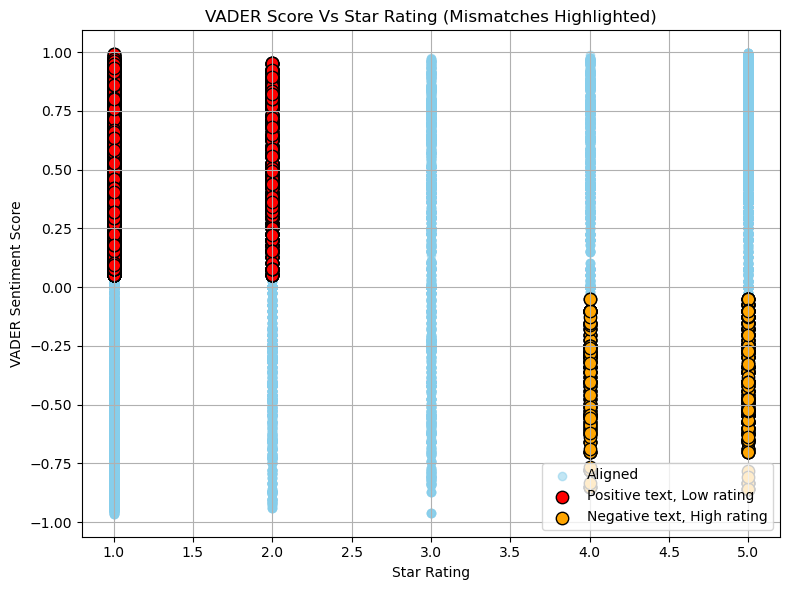

In [16]:
# Scatter plot of VADER sentiment vs star rating

# Define mismatch conditions
positive_text_low_rating = (df['vader_score'] >= 0.05) & (df['rating'] <= 2)
negative_text_high_rating = (df['vader_score'] <= -0.05) & (df['rating'] >= 4)

# Base scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df['rating'], df['vader_score'], alpha=0.5, color='skyblue', label='Aligned')

# Highlight mismatches
plt.scatter(df.loc[positive_text_low_rating, 'rating'],
            df.loc[positive_text_low_rating, 'vader_score'],
            color='red', edgecolor='black', s=80, label='Positive text, Low rating')

plt.scatter(df.loc[negative_text_high_rating, 'rating'],
            df.loc[negative_text_high_rating, 'vader_score'],
            color='orange', edgecolor='black', s=80, label='Negative text, High rating')

plt.title('VADER Score Vs Star Rating (Mismatches Highlighted)')
plt.xlabel('Star Rating')
plt.ylabel('VADER Sentiment Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../assets/Vader sentiment vs star rating.png")
plt.show()


## TF-IDF Top Keywords by Sentiment

In [17]:
# Choose which column to analyze
text_column = 'clean_review'

# Initialize CountVectorizer
vectorizer = CountVectorizer(
    stop_words='english',  # remove common stopwords
    max_features=10,       # top 50 terms
    ngram_range=(1,2)      # unigrams + bigrams
)

# Fit-transform for all reviews
X = vectorizer.fit_transform(df[text_column].fillna(''))

# Create a DataFrame of terms and frequencies
term_freq = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': X.sum(axis=0).A1})
term_freq = term_freq.sort_values(by='frequency', ascending=False)
print("Top 10 terms in all reviews:")
print(term_freq)

# Optional: Extract keywords per sentiment class
for sentiment in df['sentiment_combined'].unique():
    reviews_subset = df[df['sentiment_combined'] == sentiment][text_column].fillna('')
    X_sub = vectorizer.fit_transform(reviews_subset)
    term_freq_sub = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': X_sub.sum(axis=0).A1})
    term_freq_sub = term_freq_sub.sort_values(by='frequency', ascending=False)
    print(f"\nTop terms for {sentiment} reviews:")
    print(term_freq_sub.head(10))

Top 10 terms in all reviews:
      term  frequency
7  netflix      10604
0      app      10333
2     good       6093
9    watch       4882
6   movies       4758
4     like       3222
5     love       3105
8    shows       2998
1     dont       2408
3       im       2319

Top terms for negative reviews:
           term  frequency
1           app       3943
6       netflix       3745
9         watch       1850
3          dont       1195
5        movies       1179
0       account       1107
2           bad       1095
8  subscription       1020
7           new        991
4            im        987

Top terms for positive reviews:
      term  frequency
2     good       4768
0      app       4402
7  netflix       4104
5     love       2786
6   movies       2687
1     best       1928
9    watch       1761
3    great       1607
4     like       1570
8     nice       1307

Top terms for neutral reviews:
      term  frequency
6  netflix       2755
0      app       1988
9    watch       1271
4   

In [20]:
# Use the cleaned reviews column
texts = df['clean_review'].dropna().astype(str)

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')  # top 50 words
tfidf_matrix = vectorizer.fit_transform(texts)

# Convert to DataFrame for readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Get top keywords by average importance
top_keywords = tfidf_df.mean().sort_values(ascending=False).head(20)
print("Top Keywords by average importance:")
print(top_keywords)


Top Keywords by average importance:
app        0.103030
good       0.101739
netflix    0.089524
movies     0.047661
watch      0.045768
love       0.045726
best       0.033406
like       0.032803
shows      0.030648
nice       0.029233
great      0.029136
movie      0.027021
dont       0.025700
new        0.023034
im         0.022763
use        0.021633
time       0.021326
tv         0.020778
account    0.020523
bad        0.020342
dtype: float64


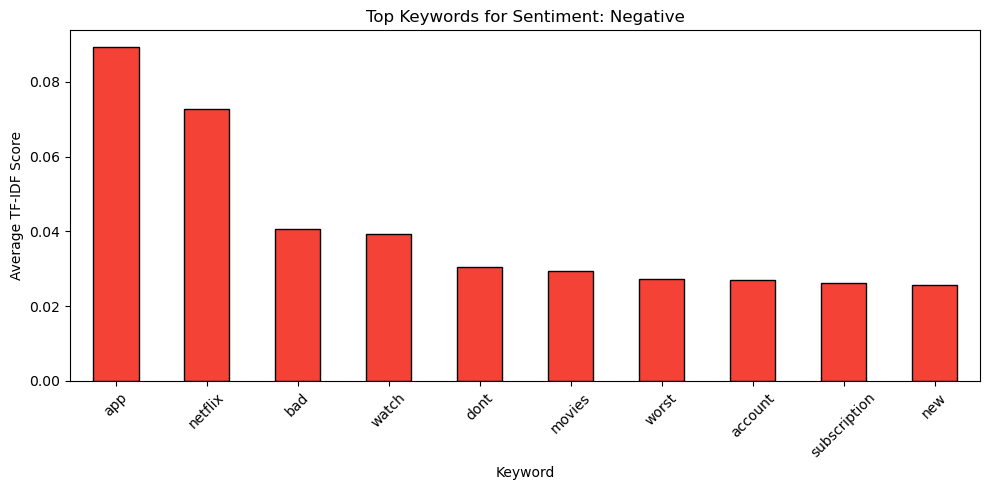

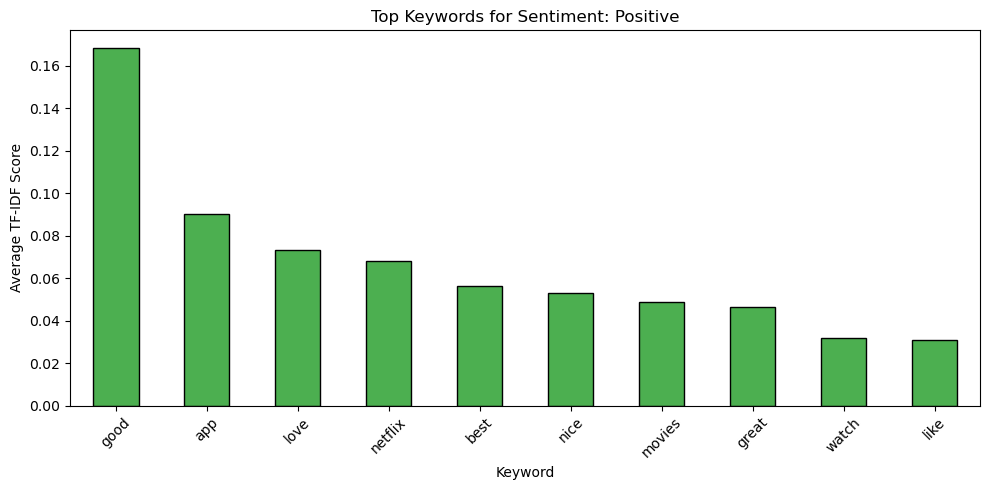

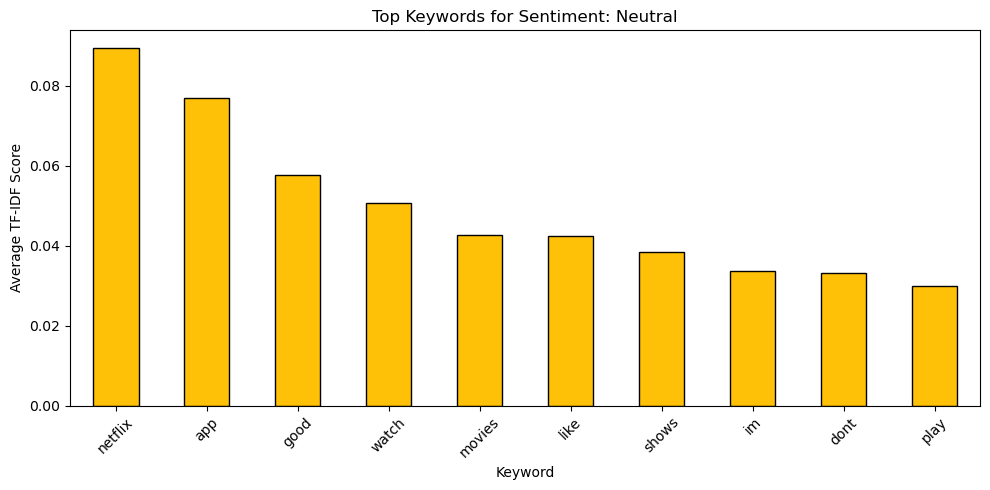

In [97]:
# -----------------------------
# Function: Top TF-IDF Keywords by Sentiment
# -----------------------------
def get_top_keywords_by_sentiment(df, sentiment_col='sentiment_combined', text_col='clean_review', n=10):
    results = {}
    for sentiment in df[sentiment_col].unique():
        subset = df[df[sentiment_col] == sentiment][text_col].dropna().astype(str)
        if subset.empty:
            continue
        vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(subset)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
        top_keywords = tfidf_df.mean().sort_values(ascending=False).head(n)
        results[sentiment] = top_keywords
    return results

# -----------------------------
# Run the function
# -----------------------------
sentiment_keywords = get_top_keywords_by_sentiment(df, n=10)

# -----------------------------
# Plot each sentiment separately
# -----------------------------
colors = {
    'positive': '#4CAF50',
    'neutral': '#FFC107',
    'negative': '#F44336'
}

for sentiment, keywords in sentiment_keywords.items():
    plt.figure(figsize=(10,5))
    keywords.plot(kind='bar', color=colors.get(sentiment, '#2196F3'), edgecolor='black')
    plt.title(f"Top Keywords for Sentiment: {sentiment.capitalize()}")
    plt.xlabel("Keyword")
    plt.ylabel("Average TF-IDF Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Save each figure separately
    plt.savefig(f"../assets/top_keywords_{sentiment}.png")
    plt.show()


In [21]:
# top bigrams and trigrams per sentiment
def top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for sentiment in df['sentiment_combined'].unique():
    subset = df[df['sentiment_combined'] == sentiment]['clean_review'].astype(str)
    print(f"\nTop bigrams for {sentiment}:")
    print(top_ngrams(subset, (2,2), 10))
    print(f"Top trigrams for {sentiment}:")
    print(top_ngrams(subset, (3,3), 10))



Top bigrams for negative:
[('worst app', 263), ('doesnt work', 202), ('wont let', 155), ('dont know', 154), ('want watch', 152), ('customer service', 147), ('waste money', 141), ('bad app', 138), ('netflix app', 134), ('watch netflix', 132)]
Top trigrams for negative:
[('problem playing video', 44), ('wont let watch', 37), ('shows payment pending', 28), ('app doesnt work', 24), ('im really disappointed', 21), ('kpop demon hunters', 21), ('monday night raw', 20), ('total waste money', 20), ('app working properly', 20), ('app keeps crashing', 20)]

Top bigrams for positive:
[('love netflix', 648), ('best app', 461), ('good app', 453), ('love app', 434), ('cheese cheese', 357), ('great app', 257), ('shows movies', 256), ('movies series', 235), ('nice app', 230), ('app good', 187)]
Top trigrams for positive:
[('cheese cheese cheese', 356), ('kpop demon hunters', 111), ('movies tv shows', 66), ('best app movies', 37), ('best movie app', 37), ('watch kpop demon', 37), ('movies series docume

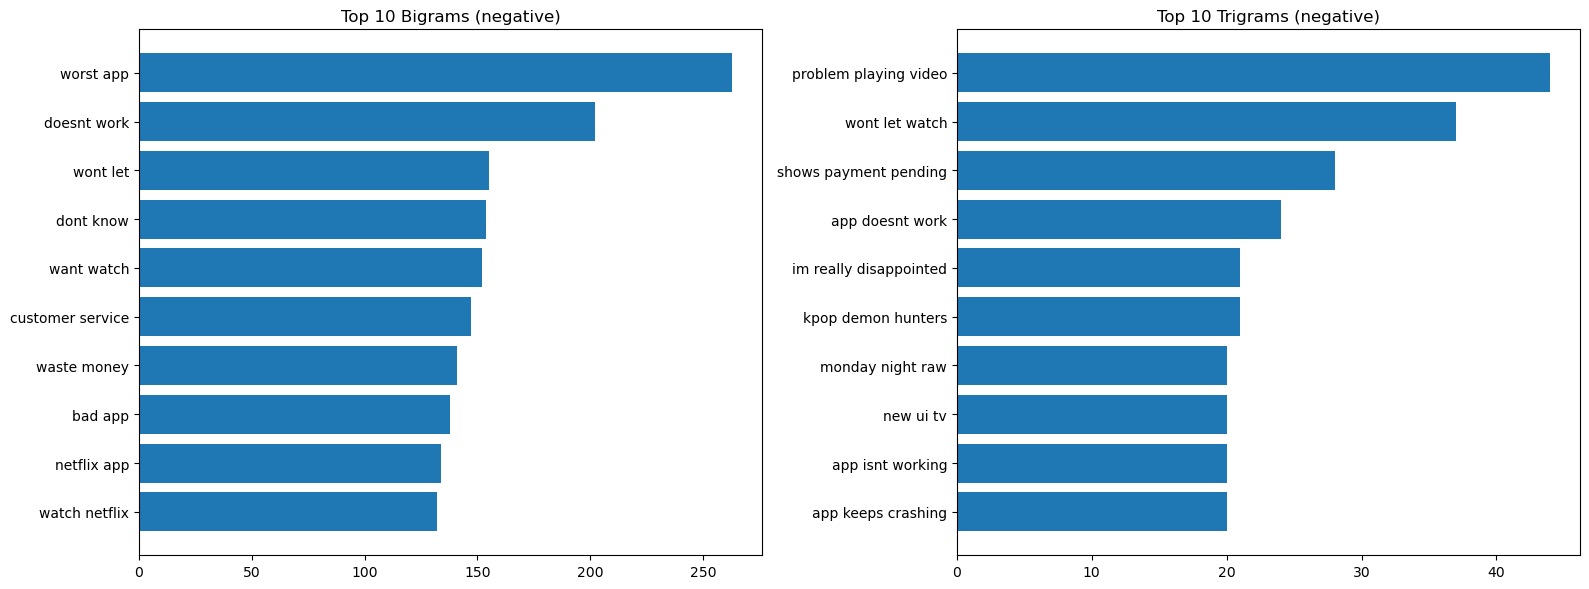

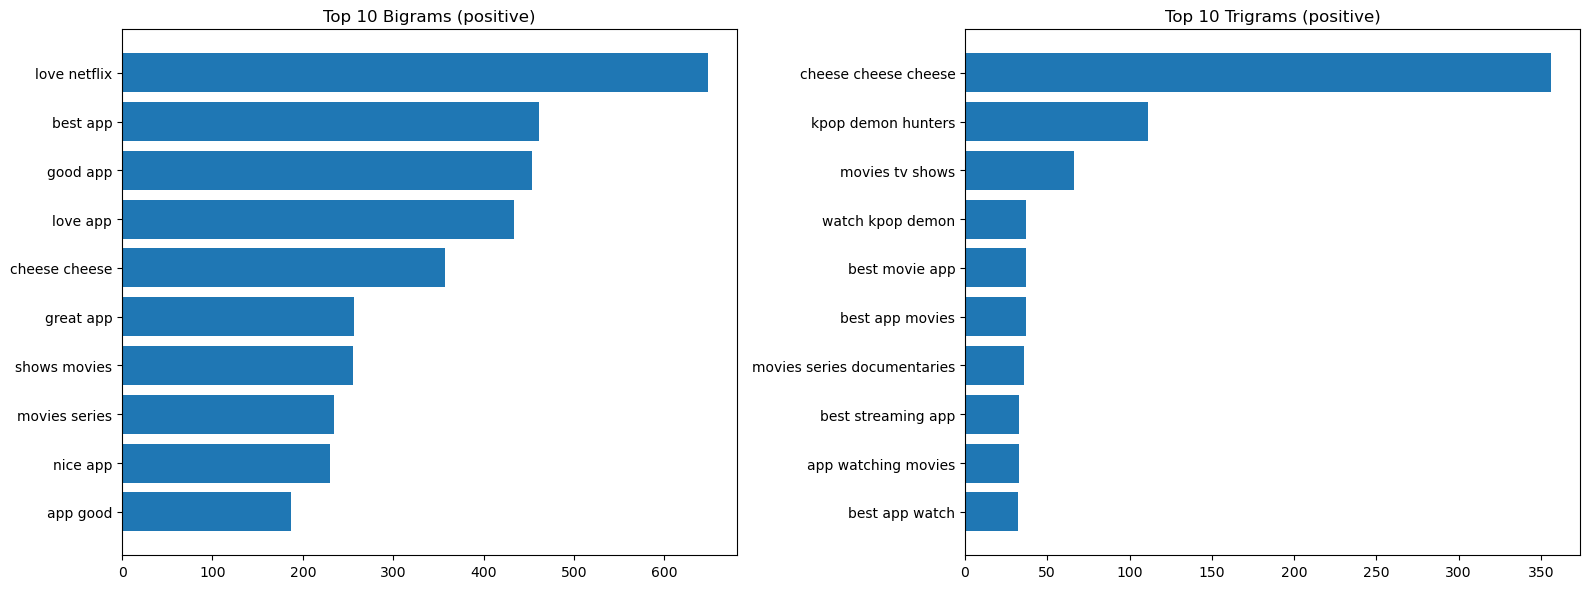

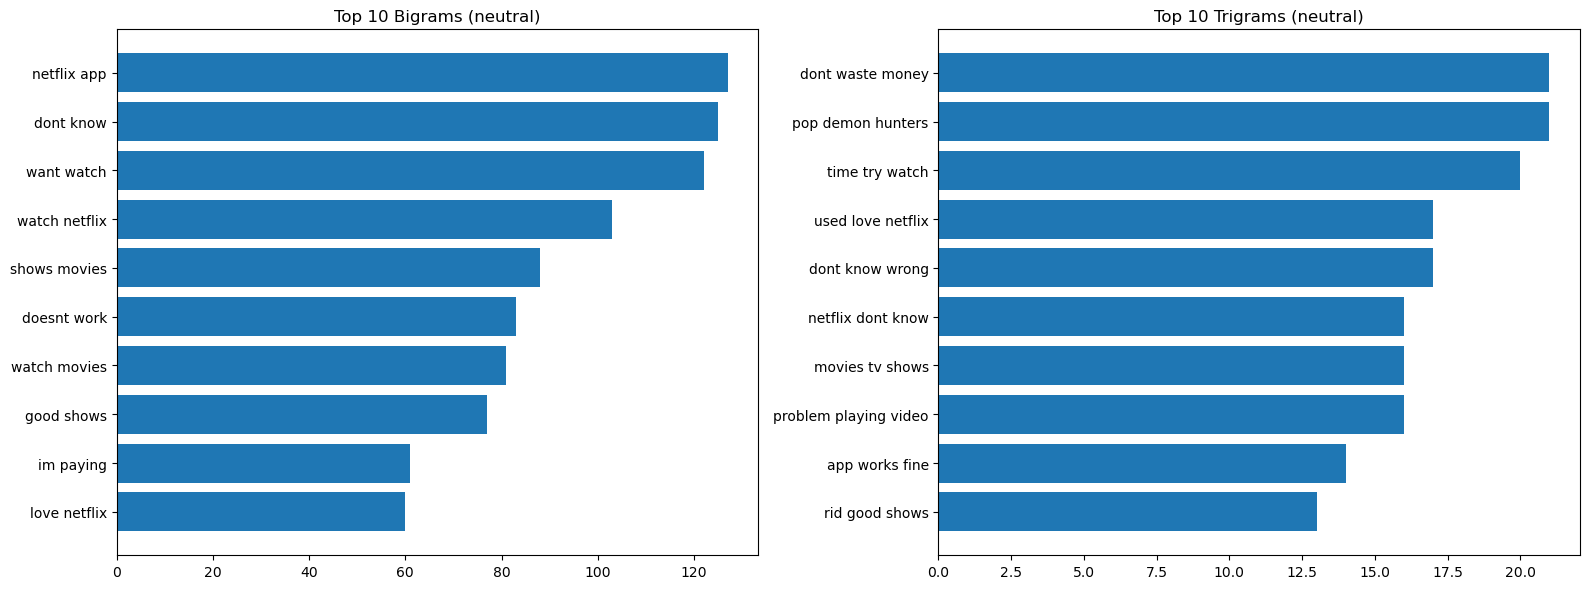

In [22]:
def plot_bigrams_trigrams(df, sentiment_label, top_n=10, save=True):
    # Filter reviews by sentiment
    reviews = df[df['sentiment_combined'] == sentiment_label]['clean_review']

    if reviews.empty:
        print(f"No reviews found for sentiment: {sentiment_label}")
        return

    # --- Bigrams ---
    vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bi_matrix = vectorizer_bi.fit_transform(reviews)
    bi_counts = bi_matrix.sum(axis=0).A1
    bigram_freq = pd.DataFrame({
        'ngram': vectorizer_bi.get_feature_names_out(),
        'count': bi_counts
    }).sort_values(by='count', ascending=False).head(top_n)

    # --- Trigrams ---
    vectorizer_tri = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    tri_matrix = vectorizer_tri.fit_transform(reviews)
    tri_counts = tri_matrix.sum(axis=0).A1
    trigram_freq = pd.DataFrame({
        'ngram': vectorizer_tri.get_feature_names_out(),
        'count': tri_counts
    }).sort_values(by='count', ascending=False).head(top_n)

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    axes[0].barh(bigram_freq['ngram'], bigram_freq['count'])
    axes[0].set_title(f"Top {top_n} Bigrams ({sentiment_label})")
    axes[0].invert_yaxis()

    axes[1].barh(trigram_freq['ngram'], trigram_freq['count'])
    axes[1].set_title(f"Top {top_n} Trigrams ({sentiment_label})")
    axes[1].invert_yaxis()

    plt.tight_layout()

    # Save separately for GitHub visualization
    if save:
        filename = f"../assets/{sentiment_label}_bigrams_trigrams.png"
        plt.savefig(filename)

    plt.show()

# Run for all sentiment classes
for sentiment in df['sentiment_combined'].unique():
    plot_bigrams_trigrams(df, sentiment, top_n=10)


## Sentiment Distribution per Source

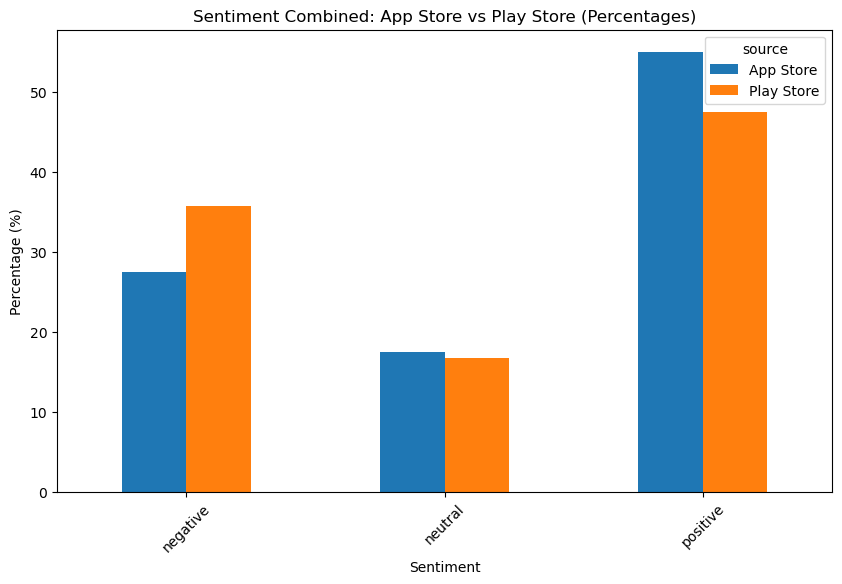

In [5]:
# Sentiment distribution per platform
sentiment_source = df.groupby(['source', 'sentiment_combined']).size().unstack(fill_value=0)

# Normalize to percentage
sentiment_source_pct = sentiment_source.div(sentiment_source.sum(axis=1), axis=0) * 100

# Plot
sentiment_source_pct.T.plot(kind='bar', figsize=(10,6))
plt.title("Sentiment Combined: App Store vs Play Store (Percentages)")
plt.ylabel("Percentage (%)")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title="source")
plt.savefig("../assets/sentiment_distribution_by_source.png")
plt.show()


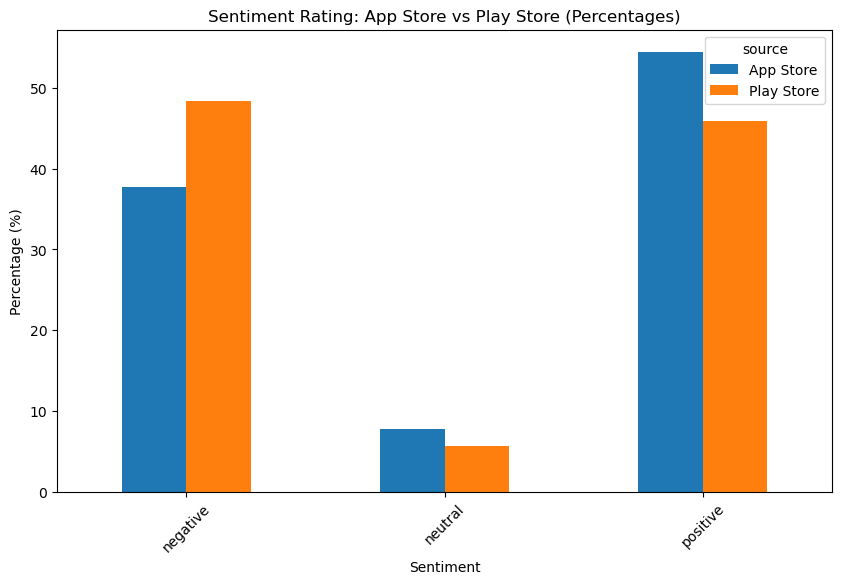

In [23]:
# Sentiment distribution per platform
sentiment_source = df.groupby(['source', 'sentiment_rating']).size().unstack(fill_value=0)

# Normalize to percentage
sentiment_source_pct = sentiment_source.div(sentiment_source.sum(axis=1), axis=0) * 100

# Plot
sentiment_source_pct.T.plot(kind='bar', figsize=(10,6))
plt.title("Sentiment Rating: App Store vs Play Store (Percentages)")
plt.ylabel("Percentage (%)")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.legend(title="source")
plt.savefig("../assets/sentiment_rating_distribution_by_source.png")
plt.show()


## Check Ratio of Imbalanced Class

In [101]:
# Class distribution
sent_counts = df['sentiment_combined'].value_counts()
sent_percent = (sent_counts / len(df)) * 100

dist_df = pd.DataFrame({
    'Count': sent_counts,
    'Percentage': sent_percent.round(2)
})

print("📊 Sentiment Class Distribution:")
print(dist_df)

# Simple imbalance check
max_pct = sent_percent.max()
min_pct = sent_percent.min()
imbalance_ratio = max_pct / min_pct if min_pct > 0 else float('inf')

print("\nImbalance Ratio (largest/smallest class):", round(imbalance_ratio, 2))

if imbalance_ratio > 3:
    print("⚠️ Dataset is highly imbalanced — could affect ML performance.")
elif imbalance_ratio > 1.5:
    print("⚠️ Moderate imbalance — may need balancing techniques (SMOTE, class weights, etc.).")
else:
    print("✅ Classes are fairly balanced.")

📊 Sentiment Class Distribution:
                    Count  Percentage
sentiment_combined                   
positive            19729       47.84
negative            14578       35.35
neutral              6931       16.81

Imbalance Ratio (largest/smallest class): 2.85
⚠️ Moderate imbalance — may need balancing techniques (SMOTE, class weights, etc.).


### EDA Completed!

➡️ Next Notebook: **05_feature_engineering.ipynb**
